In [14]:
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import json
import sys
import os
%matplotlib inline

In [15]:
metadata = OrderedDict(binaryfilename = 'test.bin',
                       fs= 512,
                       no_channels= 4,
                       no_time_points= 3600*512,
                       data_format='>i4',
                       volts_per_bit= 2.5/6/2**31, 
                       transmitter_id= '001',
                       start_timestamp_unix= 1564066727,
                       channel_labels=['channel_'+str(i) for i in range(4)],
                       duration = 3600,
                       experiment_metadata_str='kainate_acid_hippo')

def save_metadata_as_json(obj,fp):
    if not fp.endswith('.meta'):
        if fp.endswith('.bin'):
            fp = fp[:-4] 
        fp = fp + '.meta'
        
    print(fp)
    with open(fp, 'w') as json_file:
        json.dump(obj,json_file, indent=2, sort_keys=True)

def check_metadata(metadata):
    binary_file_size = os.path.getsize(metadata['binaryfilename'])
    # does file size checking require binary to be exactly like the meta (shorter files)
    # maybe dont use file size
    correct_size = ( binary_file_size == (metadata['no_time_points']*
                                   metadata['no_channels']*
                                   np.dtype(metadata['data_format']).itemsize))
    
    # itemsize attribute is the no. of bytes datatype requires 
    
    if not correct_size:
        if binary_file_size % np.dtype(metadata['data_format']).itemsize:
            print('check_metadata: data_format is probably incorrect')
        elif binary_file_size % (np.dtype(metadata['data_format']).itemsize * metadata['no_channels']):
            print('check_metadata: no_channels probably incorrect')
        else: # 
            probable_no_points = binary_file_size//(np.dtype(metadata['data_format']).itemsize*metadata['no_channels'])
            print('check_metadata: no_points probably incorrect (maybe it is',probable_no_points,'?)')
    return correct_size

#json.dump(metadata, fp='test_meta.meta')
#json.dumps(metadata, fp='test_meta_s.meta')
save_metadata_as_json(metadata, 'test.meta')

test.meta


In [16]:
with open('test.meta', 'r') as json_file:
    metadata = json.load(json_file)
print(metadata)

{'binaryfilename': 'test.bin', 'channel_labels': ['channel_0', 'channel_1', 'channel_2', 'channel_3'], 'data_format': '>i4', 'duration': 3600, 'experiment_metadata_str': 'kainate_acid_hippo', 'fs': 512, 'no_channels': 4, 'no_time_points': 1843200, 'start_timestamp_unix': 1564066727, 'transmitter_id': '001', 'volts_per_bit': 1.940255363782247e-10}


In [27]:
# make fake data
fs = metadata['fs']
t = np.linspace(start=0, stop=metadata['no_time_points']/metadata['fs'],
                num=metadata['no_time_points'],endpoint=False)
data = []
for i in range(metadata['no_channels']):
    data.append((1e-3*np.sin(2*np.pi*50*t) + 1e-4*np.sin(2*np.pi*71*t) + 1e-4*np.random.randn(*t.shape)) / metadata['volts_per_bit'])
y  = np.vstack(data).T
y = y.astype(metadata['data_format'])
y.shape

(1843200, 4)

In [28]:
t[1],y[1]

(0.001953125, array([3700406, 3540995, 3333066, 2128918]))

In [29]:
1/512

0.001953125

In [30]:
y.tofile('test.bin')

In [22]:
print(check_metadata(metadata))
metadata['no_time_points'] = 0
print(check_metadata(metadata))
metadata['no_time_points'] = 1843200

True
check_metadata: no_points probably incorrect (maybe it is 1843200 ?)
False


In [24]:
%%timeit
y2 = np.fromfile('test.bin',dtype=metadata['data_format'])
y2 = np.reshape(y2,(metadata['no_time_points'],metadata['no_channels']))

16.9 ms ± 747 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
# Load the whole array
y2 = np.fromfile('test.bin',dtype=metadata['data_format'])
y2 = np.reshape(y2,(metadata['no_time_points'],metadata['no_channels']))

# Use memory mapped array
y3 = np.memmap('test.bin',dtype = metadata['data_format'], 
               shape = (metadata['no_time_points'],metadata['no_channels']))

In [11]:
y3

memmap([[-24278769,  15006983,  41532337, -29288567],
        [ 78766610,  -3000457,  -9523674,  49124520],
        [ 77606170,  69791164, -68125098, -19928669],
        ...,
        [  7343690, -11129002, -86924148,  -9520772],
        [-39792177,  47519060,  -2835548, -86130249],
        [ -2753104, -11310219,  30331995,  76149990]], dtype=int32)

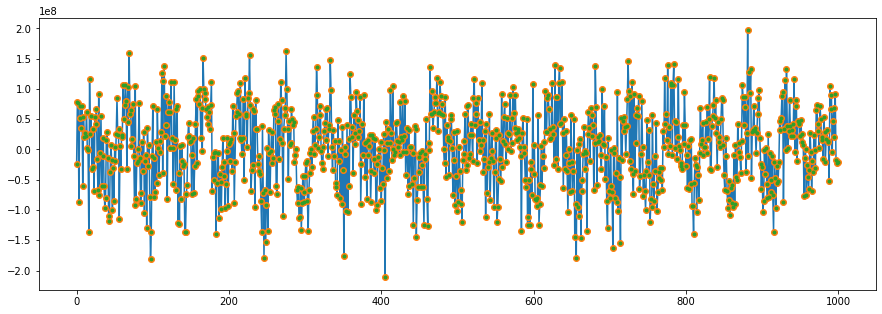

In [12]:
plt.figure(figsize=(15,5))
plt.plot(y[:1000,0])
plt.plot(y2[:1000,0],'o')
plt.plot(y3[:1000,0],'.')

##### Memory mapped arrays have a time overhead for accessing them:

In [125]:
%%time
for i in range(metadata['no_time_points']):
    np.sum(y3[i,:])

CPU times: user 31.3 s, sys: 106 ms, total: 31.4 s
Wall time: 31.5 s


In [126]:
%%time
for i in range(metadata['no_time_points']):
    np.sum(y2[i,:])

CPU times: user 10.7 s, sys: 115 ms, total: 10.8 s
Wall time: 11.2 s


##### More efficient if accessed in large chunks:

In [127]:
%%time
for i in range(metadata['no_time_points']//100):
    np.sum(y3[i*100:(i+1)*100,:])

CPU times: user 462 ms, sys: 18.7 ms, total: 480 ms
Wall time: 487 ms


In [128]:
%%time
for i in range(metadata['no_time_points']//100):
    np.sum(y2[i*100:(i+1)*100,:])

CPU times: user 189 ms, sys: 5.79 ms, total: 194 ms
Wall time: 222 ms
